<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/main/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [108]:
# df_prices = pd.read_csv('sell_prices.csv')

# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# diminuir o tamanho dos datasets
#df_prices = reduce_mem_usage(df_prices)

In [109]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

'/content/drive/MyDrive/Save/patient_dot.png'

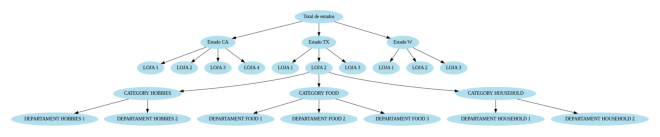

In [110]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [111]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

import numpy as np
import tensorflow as tf

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)

n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [112]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,evento,Vendas_do_dia,week_group
0,2011-01-29,11101,1,1,2011,d_1,0,4337,0
1,2011-01-30,11101,2,1,2011,d_2,0,4155,0
2,2011-01-31,11101,3,1,2011,d_3,0,2816,1
3,2011-02-01,11101,4,2,2011,d_4,0,3051,1
4,2011-02-02,11101,5,2,2011,d_5,0,2630,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0,3722,1
1909,2016-04-21,11612,6,4,2016,d_1910,0,3709,1
1910,2016-04-22,11612,7,4,2016,d_1911,0,4387,1
1911,2016-04-23,11613,1,4,2016,d_1912,0,5577,0


In [113]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'evento',
       'Vendas_do_dia', 'week_group'],
      dtype='object')


In [114]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


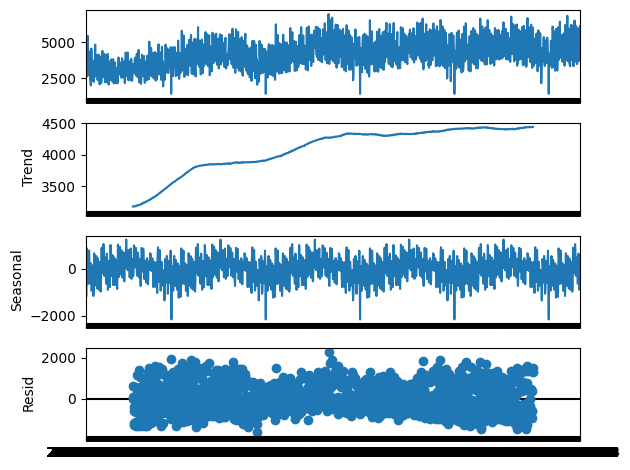

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

## Carregar dados (agora concatenados)

In [116]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

#reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [117]:
'''import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Assuming df_loja1_RNN is your DataFrame
# You should load or define your DataFrame here

num_samples = 1913  # Assuming this is the correct number of samples
time_steps = 30
input_features = 3
output_features = 1

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly

# Convert DataFrame columns to NumPy arrays
X = selected_input_columns.values
Y = selected_output_column.values

# Calculate the number of sequences based on available samples and desired time steps
num_sequences = num_samples // time_steps

# Truncate the input and output data to fit the number of sequences#
X_truncated = X[:num_sequences * time_steps].reshape(num_sequences, time_steps, input_features)
Y_truncated = Y[(time_steps + 1):(num_sequences * time_steps + 1)].reshape(num_sequences, time_steps, output_features)
'''

'import pandas as pd\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, SimpleRNN\n\n# Assuming df_loja1_RNN is your DataFrame\n# You should load or define your DataFrame here\n\nnum_samples = 1913  # Assuming this is the correct number of samples\ntime_steps = 30\ninput_features = 3\noutput_features = 1\n\n# Select specific input and output columns\n# Assuming df_loja1_RNN is your DataFrame\nselected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method\nselected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly\n\n# Convert DataFrame columns to NumPy arrays\nX = selected_input_columns.values\nY = selected_output_column.values\n\n# Calculate the number of sequences based on available samples and desired time steps\nnum_sequences = num_samples // time_steps\n\n# Truncate the input and output data to fit the number of sequences#\nX_truncated = X[

In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

import numpy as np

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 7]  # Access single column directly

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

print(selected_output_column.values)

# Fit scaler to the data and transform it
selected_input_columns = scaler.fit_transform(selected_input_columns)
selected_output_column = scaler.fit_transform(selected_output_column.values.reshape(-1, 1))

#selected_input_columns = np.tanh(selected_input_columns)
#selected_output_column = np.tanh(selected_output_column)

# Assuming you're using TensorFlow's timeseries_dataset_from_array
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

'''
input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]
dataset = timeseries_dataset_from_array(
    input_data, targets, sequence_length=7)
for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], selected_input_columns[:7])  # First sequence: steps [0-9]
    # Corresponding target: step 10
    assert np.array_equal(targets[0], selected_output_column[7])
    break

'''

import tensorflow as tf

# Assuming selected_input_columns and selected_output_column are arrays or lists
input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]

# Assuming both input_data and targets are arrays or lists
sequence_length = 7
sequences = [(input_data[i:i+sequence_length], targets[i+sequence_length]) for i in range(len(input_data) - sequence_length)]

# Extract input sequences and targets
input_sequences = [seq[0] for seq in sequences]
target_values = [seq[1] for seq in sequences]

# Convert lists to TensorFlow tensors
input_sequences_tensor = tf.constant(input_sequences, dtype=tf.float32)
target_values_tensor = tf.constant(target_values, dtype=tf.float32)

# Create a TensorFlow dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((input_sequences_tensor, target_values_tensor))

# Shuffle and batch your dataset
batch_size = 32
buffer_size = len(sequences)
dataset = dataset.shuffle(buffer_size).batch(batch_size)

for batch in dataset:
    inputs, target = batch
    # Now you can use inputs and target for training
    break

[4337 4155 2816 ... 4387 5577 6113]


In [119]:
'''
np.set_printoptions(formatter={'float_kind': '{:0.2e}'.format})
print(np.arctanh(selected_output_column))
'''

"\nnp.set_printoptions(formatter={'float_kind': '{:0.2e}'.format})\nprint(np.arctanh(selected_output_column))\n"

In [120]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [121]:
inputs, targets = batch

inputs

<tf.Tensor: shape=(32, 7, 5), dtype=float32, numpy=
array([[[5.97e-01, 1.31e-03, -2.34e-01, 6.34e-01, -2.96e-01],
        [5.97e-01, 5.01e-01, -3.91e-01, 6.34e-01, -2.96e-01],
        [5.97e-01, 1.00e+00, -4.18e-01, 6.34e-01, -2.96e-01],
        ...,
        [6.04e-01, -1.50e+00, 1.57e+00, -1.58e+00, -2.96e-01],
        [6.04e-01, -9.98e-01, 2.66e+00, -1.58e+00, -2.96e-01],
        [6.04e-01, -4.99e-01, -2.85e-02, 6.34e-01, -2.96e-01]],

       [[4.18e-01, 1.00e+00, -1.40e-01, 6.34e-01, -2.96e-01],
        [4.18e-01, 1.50e+00, -3.77e-01, 6.34e-01, 3.38e+00],
        [4.24e-01, -1.50e+00, 8.91e-01, -1.58e+00, -2.96e-01],
        ...,
        [4.24e-01, -4.99e-01, -8.67e-02, 6.34e-01, 3.38e+00],
        [4.24e-01, 1.31e-03, -1.06e+00, 6.34e-01, -2.96e-01],
        [4.24e-01, 5.01e-01, -1.08e+00, 6.34e-01, -2.96e-01]],

       [[-1.29e+00, 5.01e-01, -1.16e+00, 6.34e-01, -2.96e-01],
        [-1.29e+00, 1.00e+00, -7.12e-01, 6.34e-01, -2.96e-01],
        [-1.29e+00, 1.50e+00, -6.06e-01, 6.34

In [122]:
targets

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-2.95e-02],
       [-8.82e-01],
       [-6.75e-01],
       [1.71e+00],
       [1.56e+00],
       [4.32e-01],
       [2.85e-01],
       [1.47e+00],
       [-3.01e-01],
       [-1.73e+00],
       [1.16e+00],
       [-6.46e-01],
       [-4.69e-01],
       [9.01e-01],
       [6.51e-01],
       [-7.59e-01],
       [1.43e-01],
       [-6.78e-01],
       [4.68e-01],
       [9.46e-01],
       [-7.27e-01],
       [-7.66e-01],
       [2.22e+00],
       [-7.64e-01],
       [-1.19e+00],
       [-1.58e-01],
       [-3.98e-01],
       [2.70e-01],
       [6.18e-01],
       [-8.07e-01],
       [1.34e+00],
       [-2.24e-01]], dtype=float32)>

In [188]:
import tensorflow as tf

# Assuming 'dataset' is your BatchObject and 'train_split_ratio' is the ratio of data you want in the training set
def split_BatchDataset(dataset, train_split_ratio=0.8):
    # Get the total number of elements in the dataset
    total_elements = sum(1 for _ in dataset)

    # Calculate the number of elements for the training set
    train_elements = int(total_elements * train_split_ratio)

    # Create a dataset with train_elements elements for the training set
    train_dataset = dataset.take(train_elements)

    # Create a dataset with the remaining elements for the validation set
    test_dataset = dataset.skip(train_elements)

    return train_dataset, test_dataset

# Example usage
train_dataset, test_dataset = split_BatchDataset(dataset)

In [124]:
'''
for batch in train_dataset:
    inputs, targets = batch
    print(inputs)
    print(targets)
    break
'''

'\nfor batch in train_dataset:\n    inputs, targets = batch\n    print(inputs)\n    print(targets)\n    break\n'

In [189]:
# Define the RNN model

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional

model = Sequential([
    Bidirectional(SimpleRNN(320, return_sequences=True), input_shape=(10, 5)),
    Bidirectional(SimpleRNN(320, return_sequences=False)),
    Dense(320, activation='relu'),
    Dense(1)
])
'''


#'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

# Define the RNN model

model = Sequential([
    LSTM(50, input_shape=(7, 5), return_sequences=True),  # LSTM layer with return_sequences=True to return sequences
    Dropout(0.2),  # Dropout layer to prevent overfitting
    LSTM(50, return_sequences=False),  # Another LSTM layer without returning sequences
    Dropout(0.2),  # Dropout layer
    Dense(10, activation='relu'),  # Dense layer with ReLU activation
    Dense(1)  # Output layer
])
#'''

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=40
model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (10,5)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=300
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=300
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
'''

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
#model.fit(train_dataset, epochs=150, validation_split=0.1)

import numpy as np

# Inicializar listas para armazenar os dados
data_list = []
label_list = []

# Iterar sobre o conjunto de dados e extrair os dados e rótulos
for batch in train_dataset:
    data, label = batch  # Extrair os dados e rótulos da tupla
    data_list.append(data.numpy())  # Converter os dados para um array NumPy
    label_list.append(label.numpy())  # Converter os rótulos para um array NumPy

# Converter as listas de dados e rótulos para arrays NumPy
train_data_numpy = np.concatenate(data_list, axis=0)
train_labels_numpy = np.concatenate(label_list, axis=0)

# Agora você pode usar train_data_numpy e train_labels_numpy no método fit()
model.fit(train_data_numpy, train_labels_numpy, epochs=300, validation_split=0.2)

Epoch 1/300
39/39 [==============================] - 5s 34ms/step - loss: 0.6962 - val_loss: 0.5828
Epoch 2/300
39/39 [==============================] - 0s 9ms/step - loss: 0.4797 - val_loss: 0.4042
Epoch 3/300
39/39 [==============================] - 0s 11ms/step - loss: 0.3996 - val_loss: 0.3866
Epoch 4/300
39/39 [==============================] - 0s 9ms/step - loss: 0.3804 - val_loss: 0.3846
Epoch 5/300
39/39 [==============================] - 0s 8ms/step - loss: 0.3849 - val_loss: 0.3668
Epoch 6/300
39/39 [==============================] - 0s 8ms/step - loss: 0.3734 - val_loss: 0.3658
Epoch 7/300
39/39 [==============================] - 0s 8ms/step - loss: 0.3750 - val_loss: 0.3607
Epoch 8/300
39/39 [==============================] - 0s 8ms/step - loss: 0.3741 - val_loss: 0.3653
Epoch 9/300
39/39 [==============================] - 0s 7ms/step - loss: 0.3763 - val_loss: 0.3594
Epoch 10/300
39/39 [==============================] - 0s 7ms/step - loss: 0.3730 - val_loss: 0.3586
Epoch 1

In [190]:
# Make predictions
predictions = model.predict(test_dataset)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions:")
print(len(predictions))

12/12 [==============================] - 1s 3ms/step
Predictions:
363


[2.31e+03 2.47e+03 2.47e+03 2.50e+03 2.50e+03 2.51e+03 2.54e+03 2.59e+03
 2.60e+03 2.64e+03 2.64e+03 2.64e+03 2.64e+03 2.64e+03 2.65e+03 2.66e+03
 2.68e+03 2.69e+03 2.74e+03 2.76e+03 2.76e+03 2.76e+03 2.77e+03 2.78e+03
 2.79e+03 2.80e+03 2.80e+03 2.84e+03 2.84e+03 2.85e+03 2.86e+03 2.86e+03
 2.88e+03 2.88e+03 2.94e+03 2.94e+03 2.95e+03 2.97e+03 2.97e+03 2.98e+03
 2.98e+03 2.98e+03 2.99e+03 2.99e+03 2.99e+03 2.99e+03 2.99e+03 3.02e+03
 3.02e+03 3.02e+03 3.03e+03 3.04e+03 3.05e+03 3.05e+03 3.05e+03 3.05e+03
 3.06e+03 3.08e+03 3.08e+03 3.08e+03 3.08e+03 3.11e+03 3.13e+03 3.14e+03
 3.17e+03 3.17e+03 3.18e+03 3.20e+03 3.20e+03 3.21e+03 3.21e+03 3.21e+03
 3.22e+03 3.22e+03 3.22e+03 3.23e+03 3.25e+03 3.25e+03 3.25e+03 3.26e+03
 3.26e+03 3.26e+03 3.26e+03 3.26e+03 3.28e+03 3.29e+03 3.30e+03 3.31e+03
 3.32e+03 3.33e+03 3.33e+03 3.35e+03 3.35e+03 3.35e+03 3.36e+03 3.36e+03
 3.38e+03 3.38e+03 3.39e+03 3.39e+03 3.40e+03 3.41e+03 3.41e+03 3.43e+03
 3.45e+03 3.46e+03 3.47e+03 3.47e+03 3.48e+03 3.49e

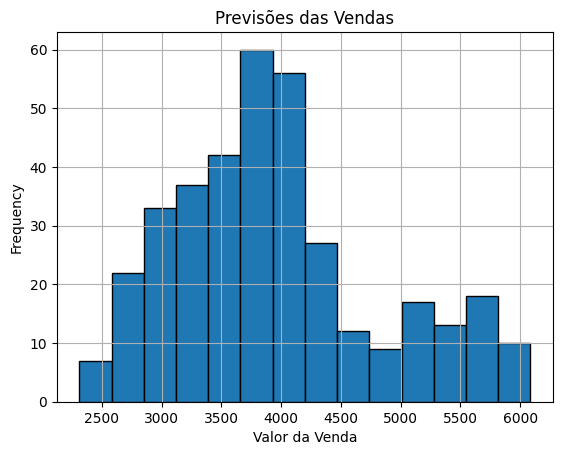

In [191]:
# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

print(unique_items)
print(frequencies)

# Assuming you have a list of data points called 'data'
plt.hist(predictions, bins='auto', edgecolor='black')  # 'auto' for automatic bin size determination
plt.xlabel('Valor da Venda')
plt.ylabel('Frequency')
plt.title('Previsões das Vendas')
plt.grid(True)  # Add grid lines
plt.show()

In [170]:
'''
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(predictions, model='additive', period=365)
decomposition.plot()
plt.show()
'''

"\nfrom statsmodels.tsa.seasonal import seasonal_decompose\n\ndecomposition = seasonal_decompose(predictions, model='additive', period=365)\ndecomposition.plot()\nplt.show()\n"

In [192]:
# Assuming test_dataset is an instance of _SkipDataset
targets_test = []

# Iterate over the dataset to extract targets
for batch in test_dataset:
    inputs, target = batch  # Adjust this line according to the actual attribute/method name
    for value in target:
      targets_test.append(value)

targets_test = scaler.inverse_transform(targets_test)

print("Targets:", len(targets_test))

Targets: 363


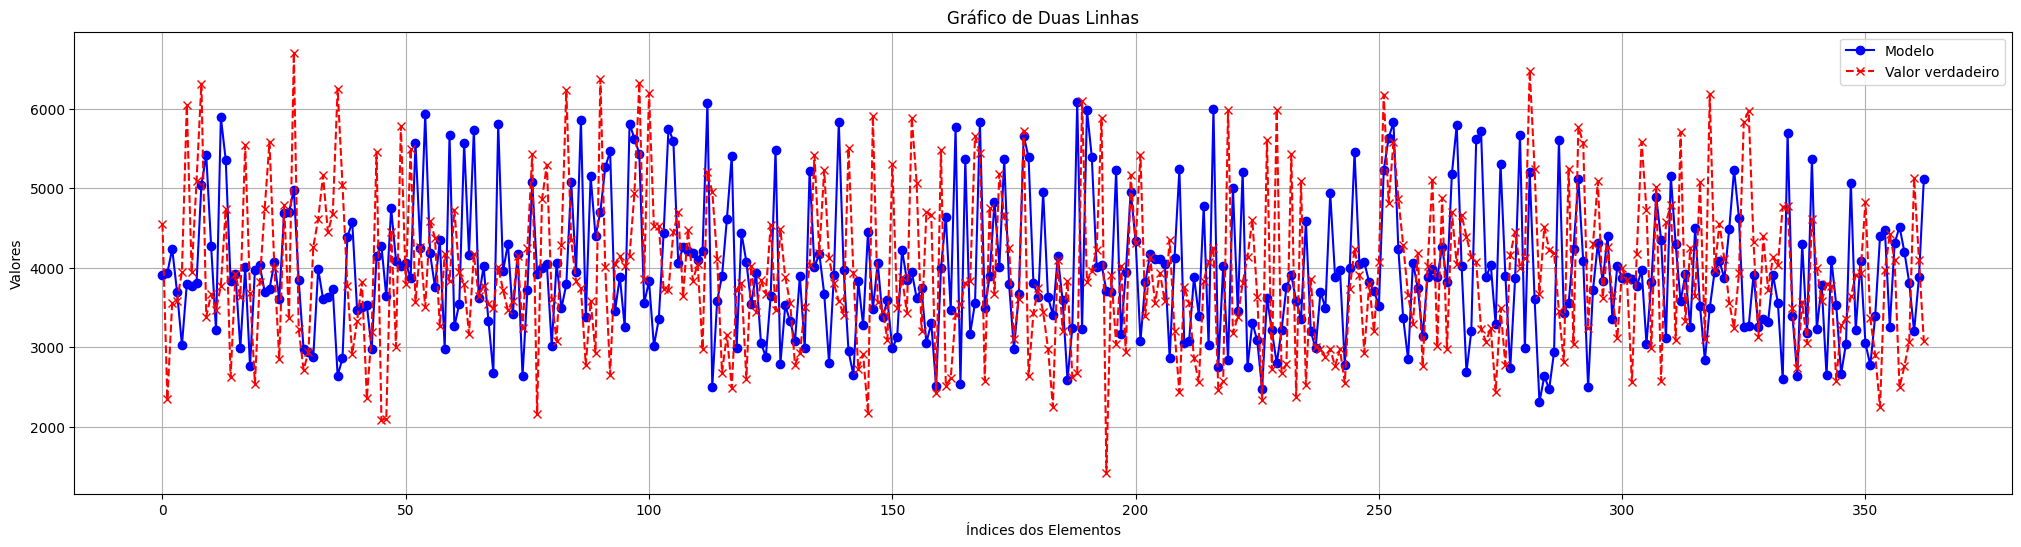

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

# Criar o gráfico de linhas
plt.plot(predictions, label='Modelo', color='blue', linestyle='-', marker='o')
plt.plot(targets_test, label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(targets_test, predictions)

# MSE calculation
mse = mean_squared_error(targets_test, predictions)

# RMSE calculation (square root of MSE)
rmse = np.sqrt(mse)

In [195]:
mae

1022.2793839712341

In [196]:
mse

1591967.3533371026

In [197]:
rmse

1261.7318864707759

In [198]:
sum(targets_test - predictions)/len(predictions)

array([-2.28e+01])

### Monte-Carlo dropout

In [136]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, Lambda
import keras.backend as K
import numpy as np

# Função para amostrar usando Monte Carlo Dropout
def mc_dropout(x):
    # Aplicar dropout
    output_with_dropout = K.dropout(x, level=dropout_rate)
    return output_with_dropout

# Definindo parâmetros de Monte Carlo Dropout
num_samples = 10  # Número de amostras de dropout
dropout_rate = 0.2  # Taxa de dropout

# Input
inputs = Input(shape=(7, 5))

# LSTM com Monte Carlo Dropout
lstm_output = LSTM(320, return_sequences=True)(inputs)
lstm_output_dropout = Lambda(mc_dropout)(lstm_output)
dropout_layer = Dropout(0.2)(lstm_output_dropout)

# LSTM com Monte Carlo Dropout
lstm_output2 = LSTM(320, return_sequences=False)(dropout_layer)
lstm_output2_dropout = Lambda(mc_dropout)(lstm_output2)
dropout_layer2 = Dropout(0.2)(lstm_output2_dropout)

# Camadas densas
dense_output = Dense(320, activation='relu')(dropout_layer2)
dense_output_dropout = Lambda(mc_dropout)(dense_output)
dropout_layer3 = Dropout(0.2)(dense_output_dropout)

# Camada de saída
output = Dense(1)(dropout_layer3)

# Modelo final
model = Model(inputs=inputs, outputs=output)

In [137]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

import numpy as np

# Train the model with Monte Carlo Dropout
def train_with_mc_dropout(model, dataset, num_epochs, num_samples):
    for epoch in range(num_epochs):
        # Inicialize as listas para armazenar as previsões de cada amostra
        predictions = []
        x_train = []
        y_train = []

        max_batch_size = max(len(batch_data) for batch_data, _ in dataset)

        for _ in range(num_samples):
            # Realize uma amostragem com dropout ativado
            preds = []
            for batch_data, batch_labels in dataset:
                # Preencha os lotes com zeros para igualar o tamanho
                padded_batch_data = np.zeros((max_batch_size, batch_data.shape[1], batch_data.shape[2]))
                padded_batch_labels = np.zeros((max_batch_size, batch_labels.shape[1]))
                padded_batch_data[:batch_data.shape[0], :, :] = batch_data
                padded_batch_labels[:batch_labels.shape[0], :] = batch_labels

                pred = model.predict(padded_batch_data)
                preds.append(pred)
                x_train.append(padded_batch_data)
                y_train.append(padded_batch_labels)
            predictions.append(np.vstack(preds))  # Empilha os resultados das previsões em um array

        # Calcule a média e variância das previsões
        mean_predictions = np.mean(predictions, axis=0)
        variance_predictions = np.var(predictions, axis=0)

        # Converta os dados de entrada e saída em numpy arrays
        x_train = np.vstack(x_train)
        y_train = np.vstack(y_train)

        # Treine o modelo com os dados e alvos do conjunto de dados
        model.train_on_batch(x_train, mean_predictions)

        # Print progresso do treinamento
        if epoch % 10 == 0:
            print("Epoch {}/{} - Loss: {:.4f}".format(epoch+1, num_epochs, np.mean(np.abs(mean_predictions - y_train))))

# Train the model
num_epochs = 30
num_samples = 10
train_with_mc_dropout(model, dataset, num_epochs, num_samples)

1/1 [==============================] - 0s 24ms/step


ValueError: Data cardinality is ambiguous:
  x sizes: 19200
  y sizes: 1920
Make sure all arrays contain the same number of samples.

# IGNORAR

A partir daqui, tem apenas código auxiliar para ajudar a obter uma versão reduzida dos dados. Por isso, irá ficar tudo em comentário.





In [ ]:
'''

# (Prices preços) Reduzir os dados para apenas de uma loja

df_prices = pd.read_csv('sell_prices.csv')

csv_path = "df_prices_Loja1.csv"
id_loja = "CA_1"
coluna = "store_id"

# Ler o arquivo CSV existente, se houver
try:
    df_existing = pd.read_csv(csv_path)
except FileNotFoundError:
    df_existing = pd.DataFrame()

index = 0
still_searching = True

while still_searching:
    actual_price = df_prices.iloc[index]
    loja = actual_price[coluna]
    if loja == id_loja:
        print(index, end=' ')
        # Adicionar a linha ao dataframe existente
        df_existing = pd.concat([df_existing, actual_price], ignore_index=True)
        index = index + 1
        continue
    still_searching = False

# Salvar o dataframe resultante no arquivo CSV, adicionando ao final do arquivo
df_existing.to_csv(csv_path, mode='a', index=False, header=not any(df_existing))

'''